# Data visualization and clustering

In the present notebook, we will visualize the global differences between both classes by using the UMAP operation. Then, we will use Principal Component Analysis (PCA) as a dimensionality reduction method to to further implement ML models to differentiate between tumor and healthy breast tissue, based on microarray data available at the NIH - Gene Expression Omnibus (Superseries [GSE70951](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70951)). According to the components that explained the variance ratio, we will consider using a reverse transform to obtain the most important features that comprise that component(s), and consider them as candidates for biomarkers (validated by gene enrichment analysis).


## Data extraction and correction

The GSE70951 is composed of two series:

* *Age and estrogen-dependent inflammation in breast adenocarcinoma and normal breast tissue [cohort_1]*, with the code [GSE70905](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70905), which will be used as an external validation dataset
* *Age and estrogen-dependent inflammation in breast adenocarcinoma and normal breast tissue [cohort_2]*, with the code [GSE70947](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70947), which will be used for biomarker discovery
We will be using the second cohort for our analysis.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The data preprocessing and differential gene expression analysis was done in R using the `limma` package.

In [ ]:
!gdown https://drive.google.com/uc?id=1tITWOKQoUZjQf1VgIaaKhxtHzImFH7fo
!gdown https://drive.google.com/uc?id=1ViDbGJZU6RfwDPAfhnF7gjcFeQtyg_u2

Downloading...
From: https://drive.google.com/uc?id=1tITWOKQoUZjQf1VgIaaKhxtHzImFH7fo
To: /content/GSE70947.csv
100% 176M/176M [00:01<00:00, 123MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ViDbGJZU6RfwDPAfhnF7gjcFeQtyg_u2
To: /content/GSE70947_DGE_filtered.csv
100% 296k/296k [00:00<00:00, 30.8MB/s]


The `GSE70947` file has the gene expression information. The columns are divided in
* `index`, which have the GEO code for each patient
* `type`, which has the class at which each patient belongs (either healthy or adenocarcinoma)
* the rest of the columns, that have the name of the gen an its expression level

In [ ]:
gse = pd.read_csv('GSE70947.csv', index_col = 0)
gse.head()

,NM_144987,NM_013290,ENST00000322831,NM_001625,lincRNA:chr7:226042-232442_R,NM_032391,ENST00000238571,XR_108906,NM_005937,NM_152493,...,NM_152343,NM_001005327,NM_001039355,lincRNA:chr21:44456656-44468556_R,lincRNA:chr9:4869500-4896050_F,NM_016053,NM_001080425,ENST00000555638,ENST00000508993,type
GSM1823702,8.710837,7.752260,6.147044,11.330250,8.049364,4.786607,5.762913,4.673030,8.595702,10.700061,...,6.452793,4.861030,10.751960,5.231761,6.099910,10.653872,8.983922,5.117210,5.231761,healthy
GSM1823703,9.386920,7.125349,7.033364,11.043588,8.546755,5.365691,5.564553,4.966745,8.505314,10.952910,...,5.836469,3.858494,11.302093,4.003188,3.858494,10.751094,8.199526,4.085583,4.355808,healthy
GSM1823704,8.958187,7.993491,6.358601,11.548966,8.616110,5.402829,5.941259,5.093209,8.683907,10.574121,...,6.668138,3.793648,10.581576,5.137291,6.605187,10.435313,8.493851,4.669778,5.225001,healthy
GSM1823705,9.034777,7.856471,6.260612,12.290221,7.724913,4.631357,6.745727,4.840550,8.573251,10.787665,...,5.905563,4.458250,11.178242,5.123130,6.739206,11.113692,8.896214,4.358008,4.631357,healthy
GSM1823706,8.822363,7.593622,6.322608,12.204265,7.785088,4.295037,6.597042,4.366717,8.788972,10.818610,...,5.672441,4.557420,12.016128,5.110453,6.496323,10.913592,9.536360,4.673507,4.557420,healthy


The `DGE` file contains the results of the differential gene expression, considering a $\log |\text{FC}| > 1$ and $\text{adj.P-val} < 0.05$ as thresholds

In [ ]:
dge = pd.read_csv('GSE70947_DGE_filtered.csv', index_col = 0)
dge.head()

,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B,diffexpressed
lincRNA:chr2:216585154-216585719_F,lincRNA:chr2:216585154-216585719_F,3.725171,7.142946,16.750688,1.316560e-44,3.454359e-40,90.700821,UP
NM_006086,NM_006086,3.048427,7.739344,16.663225,2.786762e-44,3.454359e-40,89.958877,UP
NM_004456,NM_004456,1.699635,7.972860,16.625759,3.842303e-44,3.454359e-40,89.641072,UP
NM_002141,NM_002141,-1.344960,7.782020,-16.404438,2.561246e-43,1.726984e-39,87.764022,DOWN
lincRNA:chr4:89637527-89646627_R,lincRNA:chr4:89637527-89646627_R,-1.904182,7.375651,-16.067836,4.577865e-42,2.469392e-38,84.910909,DOWN


Extracting the target,

In [ ]:
from sklearn.preprocessing import LabelEncoder
y = gse["type"]
y = LabelEncoder().fit_transform(y)

and storing the data in the variable `X`.

In [ ]:
X = gse.drop(["type"], axis = 1)
X = X[np.array(dge["ID"])]
X.head()

,lincRNA:chr2:216585154-216585719_F,NM_006086,NM_004456,NM_002141,lincRNA:chr4:89637527-89646627_R,NM_014736,NM_005480,NM_016359,NM_004336,NM_001083961,...,NM_001178126,NP113779,S77011,ENST00000498435,NM_002411,A_33_P3251412,NM_012188,NM_006552,NM_006551,NM_002652
GSM1823702,4.786607,6.321416,6.808873,8.685651,9.205305,5.675846,6.558804,6.124203,4.509872,7.197222,...,13.480088,9.728459,12.696556,9.518063,7.363144,9.754804,5.468174,7.310242,7.644311,8.949257
GSM1823703,7.644079,9.365653,7.938209,7.063652,7.311140,7.116449,7.892767,7.016965,4.633230,8.543367,...,13.369119,10.337995,12.618046,10.213340,12.581711,8.704484,6.232431,11.249700,11.713772,13.530426
GSM1823704,4.687383,4.830394,6.870517,8.485212,10.360521,5.066081,6.646007,4.805947,3.501254,7.634662,...,10.077759,6.817671,9.302829,6.409630,3.621975,6.006907,1.449203,4.598337,4.635677,4.456936
GSM1823705,5.097593,5.676941,7.078230,8.328697,9.077607,5.916410,6.553197,5.758328,4.256620,7.382161,...,13.854754,11.696181,12.933871,10.968928,11.478130,9.929380,8.450231,11.012945,11.134689,12.588631
GSM1823706,5.012687,5.626693,7.558369,8.562031,9.844757,6.741824,6.729353,6.239319,5.328063,7.545784,...,17.035073,14.224910,16.074557,13.696180,16.456441,13.741491,7.200912,15.944112,15.928179,17.924073


## UMAP visualization

The implementation of the UMAP operation will be done using the `umap-learn` package, whose documentation can be found [here](https://umap-learn.readthedocs.io/en/latest/plotting.html).

In [ ]:
!pip install -q umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q datashader bokeh holoviews colorcet scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


<Axes: >

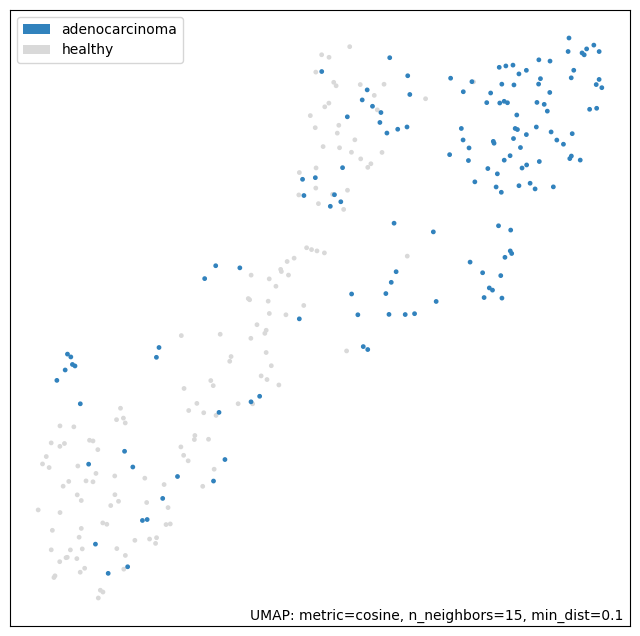

In [ ]:
#@title UMAP for the complete dataset
import umap
expr_gen = gse.drop(["type"], axis = 1)
mapper = umap.UMAP(metric = 'cosine', random_state = 42).fit(expr_gen)

import umap.plot
umap.plot.points(mapper, labels = gse['type'],
                 background = 'white', color_key_cmap = 'tab20c')

<Axes: >

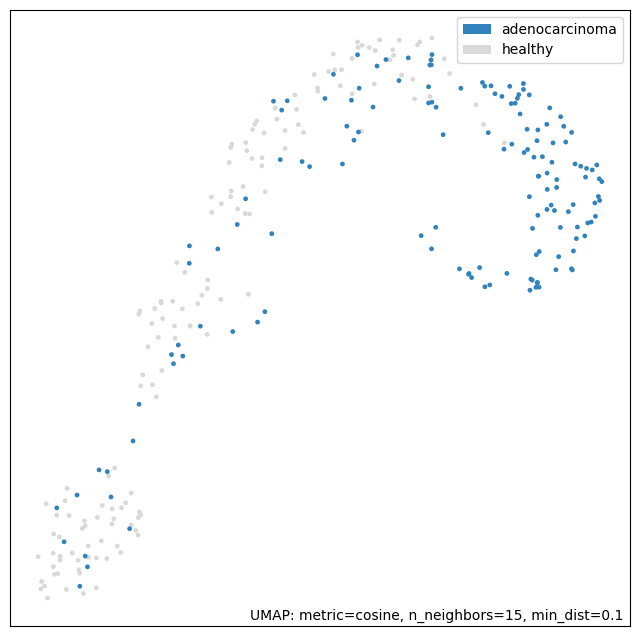

In [ ]:
#@title UMAP after DGE
expr_gen = X
mapper = umap.UMAP(metric = 'cosine', random_state = 42).fit(expr_gen)
umap.plot.points(mapper, labels = gse['type'],
                 background = 'white', color_key_cmap = 'tab20c')

## PCA visualization

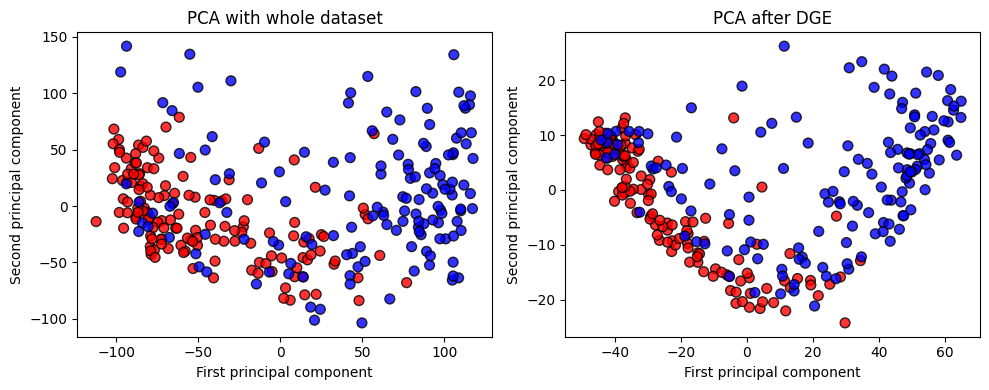

In [ ]:
#@title 2-component PCA

# PCA for complete dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
standard_data = scaler.fit_transform(gse.drop(["type"], axis = 1))

from sklearn.decomposition import PCA

pca_all = PCA(n_components = 2)
pca_comp_all = pca_all.fit_transform(standard_data)

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)

from matplotlib.colors import ListedColormap
mycmap = ListedColormap(["blue", "red"])

ax1.scatter(pca_comp_all[:,0],pca_comp_all[:,1], c = y, marker = 'o', alpha = 0.8, s = 50, cmap = mycmap, edgecolor = 'k')
ax1.set_xlabel('First principal component')
ax1.set_ylabel('Second principal component')
ax1.set_title('PCA with whole dataset')

# PCA after DGE
scaler = StandardScaler()
standard_data = scaler.fit_transform(X)

pca_dge = PCA(n_components = 2)
pca_comp_dge = pca_dge.fit_transform(standard_data)

ax2 = plt.subplot(122)

ax2.scatter(pca_comp_dge[:,0],pca_comp_dge[:,1], c = y, marker = 'o', alpha = 0.8, s = 50, cmap = mycmap, edgecolor = 'k')
ax2.set_xlabel('First principal component')
ax2.set_ylabel('Second principal component')
ax2.set_title('PCA after DGE')

plt.tight_layout()
plt.show()


We can observe how the two classes are differentiable when comparing both PCA components, but there is considerable overlap, which might difficult clustering. Therefore, we will explore the visualization with 3 components.

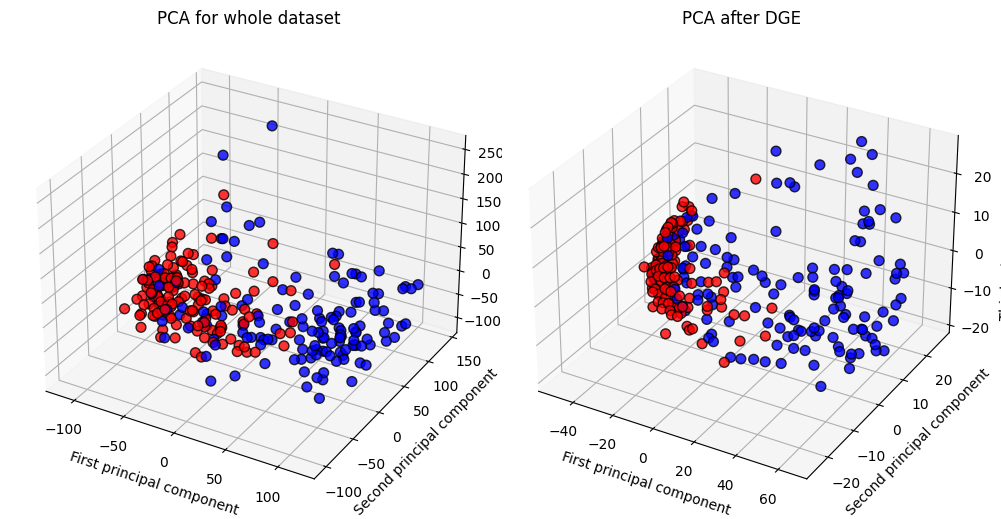

In [ ]:
#@title 3-component PCA for complete dataset

# PCA for whole dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
standard_data = scaler.fit_transform(gse.drop(["type"], axis = 1))

from sklearn.decomposition import PCA

pca_all = PCA(n_components = 3)
pca_comp_all = pca_all.fit_transform(standard_data)

plt.figure(figsize=(10, 7))
ax1 = plt.subplot(121, projection="3d")

from matplotlib.colors import ListedColormap
mycmap = ListedColormap(["blue", "red"])

ax1.scatter3D(pca_comp_all[:,0], pca_comp_all[:,1], pca_comp_all[:,2], c = y, marker = 'o', alpha=0.8, s=50, cmap=mycmap, edgecolor='k')
ax1.set_xlabel('First principal component')
ax1.set_ylabel('Second principal component')
ax1.set_zlabel('Third principal component')
ax1.set_title('PCA for whole dataset')

# PCA after DGE
scaler = StandardScaler()
standard_data = scaler.fit_transform(X)

pca_dge = PCA(n_components = 3)
pca_comp_dge = pca_dge.fit_transform(standard_data)

ax2 = plt.subplot(122, projection="3d")

from matplotlib.colors import ListedColormap
mycmap = ListedColormap(["blue", "red"])

ax2.scatter3D(pca_comp_dge[:,0], pca_comp_dge[:,1], pca_comp_dge[:,2], c = y, marker = 'o', alpha=0.8, s=50, cmap=mycmap, edgecolor='k')
ax2.set_xlabel('First principal component')
ax2.set_ylabel('Second principal component')
ax2.set_zlabel('Third principal component')
ax2.set_title('PCA after DGE')

plt.tight_layout()
plt.show()


There is still some degree of overlap, but after the DGE, the clusters that represent each class are readily more differentiable, but more sparse.

After visualization, we will used a number of components such that the cumulative explained variances $\ge 95\%$.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
standard_data = scaler.fit_transform(X)

from sklearn.decomposition import PCA

pca = PCA(n_components = 0.95)
pca_comp = pca.fit_transform(standard_data)

components = len(pca.explained_variance_ratio_)
print(f'Number of components: {components}')

Number of components: 99


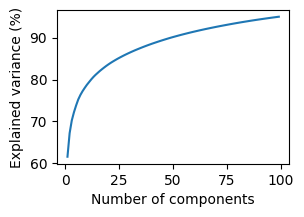

In [ ]:
# Visualizing cumulative variance
plt.figure(figsize = (3,2))
plt.plot(range(1, components + 1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")
plt.show()

In [ ]:
pca.explained_variance_ratio_

array([0.61560644, 0.05628967, 0.03040079, 0.0194938 , 0.01626052,
       0.01440903, 0.01082484, 0.00898563, 0.00782558, 0.00731991,
       0.00644676, 0.00637286, 0.0058178 , 0.00516977, 0.00465901,
       0.00461957, 0.00420454, 0.00405703, 0.00387961, 0.00365047,
       0.00345424, 0.00321437, 0.00308498, 0.00297764, 0.00284751,
       0.002717  , 0.00267781, 0.00254023, 0.0024712 , 0.00239225,
       0.00232731, 0.00227176, 0.0021711 , 0.00211392, 0.00207488,
       0.0020527 , 0.00196955, 0.0019537 , 0.00188243, 0.00183749,
       0.00178587, 0.0017344 , 0.00171945, 0.00169889, 0.00164702,
       0.0016174 , 0.00158238, 0.0015695 , 0.00152252, 0.00145218,
       0.00143704, 0.00140515, 0.00139695, 0.00136413, 0.00132134,
       0.00130754, 0.00128595, 0.00126427, 0.00123705, 0.00120461,
       0.00119977, 0.00118416, 0.00115033, 0.00114225, 0.00111922,
       0.00108843, 0.00107727, 0.00105931, 0.00105304, 0.00103915,
       0.00101091, 0.00099125, 0.0009735 , 0.00097259, 0.00096

For exploring, we will recover the first 5 features that explained each component.

In [ ]:
df_comp = {'1st': [], '2nd': [], '3rd': [], '4th': [], '5th': []}
for row in range(pca_comp.shape[0]):

    temp = np.argpartition(-(pca_comp[row]), 5)

    indices = temp[np.argsort((-pca_comp[row])[temp])][:5]

    df_comp['1st'].append(X.columns[indices][0])
    df_comp['2nd'].append(X.columns[indices][1])
    df_comp['3rd'].append(X.columns[indices][2])
    df_comp['4th'].append(X.columns[indices][3])
    df_comp['5th'].append(X.columns[indices][4])

df_comp = pd.DataFrame(df_comp)
df_comp

,1st,2nd,3rd,4th,5th
0,NM_004456,NM_004336,NM_016359,lincRNA:chr4:89637527-89646627_R,NM_001002033
1,lincRNA:chr4:89637527-89646627_R,NM_004456,NM_006086,NM_181803,NM_016359
2,NM_006086,lincRNA:chr4:89637527-89646627_R,NM_002141,NM_024693,NM_002417
3,NM_020675,NM_014736,NM_002141,NM_181803,NM_004336
4,NM_001002033,NM_014736,NM_020675,NM_181803,NM_182687
...,...,...,...,...,...
285,lincRNA:chr2:216585154-216585719_F,NM_000088,NM_005480,NM_016359,NM_002263
286,lincRNA:chr2:216585154-216585719_F,NM_005480,NM_006086,NM_002417,NM_003579
287,NM_004456,NM_001002033,NM_002417,NM_002487,NM_170589
288,lincRNA:chr2:216585154-216585719_F,NM_006086,NM_018410,NM_001083961,NM_000493


## Machine learning models

At the expense of interpretability, we would use the PCA components as inputs for machine learning binary classifiers.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pca_comp,
                                                    y,
                                                    test_size = 0.33,
                                                    random_state = 42)

In [ ]:
#@title Classifiers´ implementation

clf = []

# Utilizaremos GridSearch para obtener los mejores parámetros para cada clasificador
from sklearn.model_selection import GridSearchCV

# Dummy classifier for baseline
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
clf.append(dummy_clf)

# Logistic Regression
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
clf.append(lr_clf)

# Support Vector Machine
from sklearn.svm import SVC

param_grid = {'kernel': ['linear', 'poly', 'rbf'],
              'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.001, 0.0001]}

svm_clf = SVC()
svm_GS = GridSearchCV(svm_clf, param_grid)
clf.append(svm_GS)

# Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': [10,50,100,200, 1000],
              'min_weight_fraction_leaf': [0.0, 0.5],
              'max_features': ['sqrt', 'log2']
              }

rf_clf = RandomForestClassifier()
rf_GS = GridSearchCV(rf_clf, param_grid)
clf.append(rf_GS)

# K-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': np.arange(5,21),
              }

knn_clf = KNeighborsClassifier()
knn_GS = GridSearchCV(knn_clf, param_grid)
clf.append(knn_GS)

from xgboost import XGBClassifier

param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4],
              'learning_rate': [0.01, 0.03, 0.06, 0.1],
              'max_depth': [5,6,7,8],
              'n_estimators': [50,65,80,100,115,130,150],
              }

xgb_clf = XGBClassifier(objective="binary:logistic")
xgb_GS = GridSearchCV(xgb_clf, param_grid)
clf.append(xgb_GS)

# Fit
for model in clf:
  model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
#@title Performance metrics
y_pred = [model.predict(X_test) for model in clf]
labels = ["Dummy Classifier", "Logistic regression", "SVM", "Random Forest", "KNN", "XGBoost"]
metrics = {'Accuracy':list(), 'F1 score':list(), 'Precision':list(), 'Recall':list(), 'AUC': list()}

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

for j in range(len(y_pred)):
  metrics['Accuracy'].append(accuracy_score(y_test, y_pred[j]))
  metrics['F1 score'].append(f1_score(y_test, y_pred[j],))
  metrics['Precision'].append(precision_score(y_test, y_pred[j],))
  metrics['Recall'].append(recall_score(y_test, y_pred[j],))
  metrics['AUC'].append(roc_auc_score(y_test, y_pred[j],))

df_metrics = pd.DataFrame(metrics)
df_metrics.insert(0, 'Clasificadores', labels)
df_metrics.set_index('Clasificadores', inplace=True)
print(df_metrics)

                     Accuracy  F1 score  Precision    Recall       AUC
Clasificadores                                                        
Dummy Classifier     0.447917  0.000000   0.000000  0.000000  0.500000
Logistic regression  0.843750  0.857143   0.865385  0.849057  0.843133
SVM                  0.833333  0.846154   0.862745  0.830189  0.833699
Random Forest        0.854167  0.867925   0.867925  0.867925  0.852567
KNN                  0.854167  0.875000   0.830508  0.924528  0.845985
XGBoost              0.864583  0.880734   0.857143  0.905660  0.859807


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
